# 1.3.2 Explore My Model
# Note: Hardward settings should be: 
+ **GPU model: P100,  connection: 10ge or higher, one GPU per chunk!,  CPU: 4, Memory: 63GB, Chunk: 2**

# Problems that I have met and need to Check:
+ hardware setting in palmetto should be **GPU model: P100,  connection: 10ge or higher, one GPU per chunk!,  CPU: 4, Memory: 63GB, Chunk: 2**.  **The number of GPU should be 1**, otherwise, pytorch will raise Runtime Error: Memory is illegal and can not be accessed.
I have not figure out why this happen. I may do this later
+ In Neural network model, the output should be  avgpooling -> linear(in_fea, 200)-> relu -> linear(200, 1), **we have 2 linear layers after convolution**
+ in reshaping batch samples: **Use permute to transpose sample, NOT view!**， using view() could lead to disorder of data (different axises of data are mixed together!)
+ Use linear layer output + BCEWithlogitLoss  Or  sigmoid output + BCELoss
+ **(Main reason why my model is underfitting)Use Adam or AdaGrad Optimizer in this experiment, Don't Use SGD!** Since the Loss is too large when SGD and hard to optimize
+ If you see the training accuracy doesn't increase and model doesn't fit in pytorch, **Reset the notebook or Re-check the program! Sometimes the notebook stores some previous data we don't want to see, but the was used in notebook!**
+ **Note: When splitting dataset using random, or training model using random, Use the same random seed! because we want to make results reproductible!**

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import optim, nn
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from dataset import create_train_test_file_list, Person_MealsDataset, balance_data_indices


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Device: ",device,"Device Count: ", torch.cuda.device_count(), "Device Name: ",torch.cuda.get_device_name()  )
    print("Torch version:", torch.__version__)


Device:  cuda Device Count:  2 Device Name:  Tesla V100-PCIE-16GB
Torch version: 1.7.1


In [2]:
EPOCHS = 10
winmin = 1 
stridesec = 1

meal_data_train = Person_MealsDataset(person_name= "wenkanw", file_name = "train_files", winmin = winmin,stridesec = stridesec)
meal_data_test = Person_MealsDataset(person_name= "wenkanw", file_name = "test_files", winmin = winmin,stridesec = stridesec)

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-3-20/10-3-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-27-20/9-27-20.shm
Loading File:  ../data/I

In [3]:
batch_size = 128
random_seed = 1000
torch.manual_seed(random_seed)


# load
print("Training using every file\n")
trainingsamples,traininglabels =  meal_data_train.data_indices, meal_data_train.labels
testsamples,testlabels =  meal_data_test.data_indices, meal_data_test.labels

print("Creating balanced training data array")

train_shuffledUnderSampledBalancedIndices = balance_data_indices(traininglabels,mode="under", shuffle=True)
# balancedData,balancedLabels = meal_data_train.get_subset( train_shuffledUnderSampledBalancedIndices)

test_shuffledUnderSampledBalancedIndices = balance_data_indices(testlabels,mode="under", shuffle=True)
# balancedData_test,balancedLabels_test = meal_data_test.get_subset( test_shuffledUnderSampledBalancedIndices)


train_set_balanced = torch.utils.data.Subset(meal_data_train, train_shuffledUnderSampledBalancedIndices)
test_set_balanced = torch.utils.data.Subset(meal_data_test, test_shuffledUnderSampledBalancedIndices)

train_loader = torch.utils.data.DataLoader(train_set_balanced,batch_size=batch_size, shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set_balanced ,batch_size=batch_size, shuffle=True,num_workers=2)

print("Data Loader Created")

Training using every file

Creating balanced training data array
Data Loader Created


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 1.)
#         nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
#         nn.init.normal_(m.weight.data, 0.0, 0.01)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
        
from torch import nn
class Discriminator(nn.Module):
    def __init__(self, ngpu, input_shape , out_fea = 1):
        super(Discriminator, self).__init__()
        
        # (input_shape[0], input_shape[1] )=  (number of data point, 6 axis channel )
        in_channels, win_size = input_shape[0], input_shape[1]
        self.in_channels = in_channels
        self.ngpu = ngpu  
        self.out_fea = out_fea
        filter_size = 10
        self.conv0 = nn.Conv1d(in_channels = self.in_channels, 
                               out_channels = filter_size, 
                               kernel_size= 44,  stride= 2, padding=0, bias=False)
        
        self.relu0= nn.ReLU()
        
        self.conv1 = nn.Conv1d(filter_size,filter_size, kernel_size= 20,stride= 2, padding=0, bias=False)
        self.relu1= nn.ReLU()
        
        self.conv2 = nn.Conv1d(filter_size,filter_size, kernel_size= 4, stride= 2, padding=0, bias=False)
        self.relu2= nn.ReLU()
        
#         self.conv3 = nn.Conv1d(filter_size,filter_size, kernel_size= 4, stride= 2, padding=0, bias=False)
#         self.relu3= nn.LeakyReLU(0, inplace=True)
        
        self.avgpool = nn.AvgPool1d(kernel_size=10)
        self.flatten = nn.Flatten()
        self.linear1 = None 
        self.relu4 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=200, out_features=out_fea, bias=True)
        self.softmax = nn.Softmax(dim=out_fea)
        self.sigmoid = nn.Sigmoid()
        
        nn.init.normal_(self.conv0.weight.data, 0.0, 1.)
        nn.init.normal_(self.conv1.weight.data, 0.0, 1.)
        nn.init.normal_(self.conv2.weight.data, 0.0, 1.)
        nn.init.normal_(self.linear2.bias.data, 0.0, 1.)
        #nn.init.normal_(self.conv0.bias.data, 0.0, 1.)
        #nn.init.normal_(self.conv1.bias.data, 0.0, 1.)
        #nn.init.normal_(self.conv2.bias.data, 0.0, 1.)
#         nn.init.normal_(self.avgpool.weight.data, 0.0, 1.)
        
    def l1_loss(self,factor=0.01):
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        loss = 0.
        layers = [self.conv0, self.conv1, self.conv2]
        for layer in layers:
            for p in layer.parameters():
                #print(p)
                reg_loss += l1_crit(p, torch.zeros(p.shape))

        loss = factor * reg_loss
        return loss

    def forward(self, input):
#         print("input shape:",input.shape)
        x = input.permute(0,2,1)
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.avgpool(x)
        #print("Pooling shape:",x.shape)
        x = self.flatten(x)
        if self.linear1 == None:
            self.linear1 = nn.Linear(in_features=x.shape[1], out_features=200, bias=True)
            nn.init.normal_(self.linear1.weight.data, 0.0, 1.)
            nn.init.normal_(self.linear1.bias.data, 0.0, 1.)
            
        x = self.relu4(self.linear1(x))
        out = self.linear2(x)
#         out = self.sigmoid(x)

        return out


In [30]:
class Discriminator_BN(nn.Module):
    def __init__(self, ngpu, input_shape , out_fea = 1):
        super(Discriminator_BN, self).__init__()
        
        # (input_shape[0], input_shape[1] )=  (number of data point, 6 axis channel )
        in_channels, win_size = input_shape[0], input_shape[1]
        self.in_channels = in_channels
        self.ngpu = ngpu  
        self.out_fea = out_fea
        filter_size = 10
        self.conv0 = nn.Conv1d(in_channels = self.in_channels, 
                               out_channels = filter_size, 
                               kernel_size= 44,  stride= 2, padding=0, bias=False)
        
        self.relu0= nn.ReLU()
#         num_fea = (win_size-20)//2
        self.conv1 = nn.Conv1d(filter_size,filter_size, kernel_size= 20,stride= 2, padding=0, bias=False)
        self.relu1= nn.ReLU()
#         num_fea = (num_fea-20)//2
        self.bn1 = nn.BatchNorm1d(filter_size)
        
        self.conv2 = nn.Conv1d(filter_size,filter_size, kernel_size= 4, stride= 2, padding=0, bias=False)
        self.relu2= nn.ReLU()
        
        
        self.bn2 = nn.BatchNorm1d(filter_size)
        
        
        self.avgpool = nn.AvgPool1d(kernel_size=10)
        self.flatten = nn.Flatten()
        self.linear1 = None 
        self.relu4 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=200, out_features=out_fea, bias=True)
        self.softmax = nn.Softmax(dim=out_fea)
        self.sigmoid = nn.Sigmoid()
        
        nn.init.normal_(self.conv0.weight.data, 0.0, 1.)
        nn.init.normal_(self.conv1.weight.data, 0.0, 1.)
        nn.init.normal_(self.conv2.weight.data, 0.0, 1.)
        nn.init.normal_(self.linear2.bias.data, 0.0, 1.)
        #nn.init.normal_(self.conv0.bias.data, 0.0, 1.)
        #nn.init.normal_(self.conv1.bias.data, 0.0, 1.)
        #nn.init.normal_(self.conv2.bias.data, 0.0, 1.)
#         nn.init.normal_(self.avgpool.weight.data, 0.0, 1.)
        
    def l1_loss(self,factor=0.01):
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        loss = 0.
        layers = [self.conv0, self.conv1, self.conv2]
        for layer in layers:
            for p in layer.parameters():
                #print(p)
                reg_loss += l1_crit(p, torch.zeros(p.shape))

        loss = factor * reg_loss
        return loss

    def forward(self, input):
#         print("input shape:",input.shape)
        x = input.permute(0,2,1)
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.conv1(x)
        x=  self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x=  self.bn2(x)
        x = self.relu2(x)
        x = self.avgpool(x)
        #print("Pooling shape:",x.shape)
        x = self.flatten(x)
        if self.linear1 == None:
            self.linear1 = nn.Linear(in_features=x.shape[1], out_features=200, bias=True)
            nn.init.normal_(self.linear1.weight.data, 0.0, 1.)
            nn.init.normal_(self.linear1.bias.data, 0.0, 1.)
            
        x = self.relu4(self.linear1(x))
        out = self.linear2(x)

        return out

# Model with batch norm + bias 

In [83]:
class Discriminator_BN_Bias(nn.Module):
    def __init__(self, ngpu, input_shape , out_fea = 1, bias=True):
        super(Discriminator_BN_Bias, self).__init__()
        
        # (input_shape[0], input_shape[1] )=  (number of data point, 6 axis channel )
        in_channels, win_size = input_shape[0], input_shape[1]
        self.in_channels = in_channels
        self.ngpu = ngpu  
        self.out_fea = out_fea
        filter_num = 10
        
        self.conv0 = nn.Conv1d(in_channels = self.in_channels, 
                               out_channels = filter_num, 
                               kernel_size= 44,  stride= 2, padding=0, bias=bias)
        
        self.relu0= nn.ReLU()
        num_fea = (win_size-44)//2 +1
        self.conv1 = nn.Conv1d(filter_num,filter_num, kernel_size= 20,stride= 2, padding=0, bias=bias)
        self.relu1= nn.ReLU()
        num_fea = (num_fea-20)//2 +1
        
        self.bn1 = nn.BatchNorm1d(filter_num)
        
        self.conv2 = nn.Conv1d(filter_num,filter_num, kernel_size= 4, stride= 2, padding=0, bias=bias)
        self.relu2= nn.ReLU()
        
        num_fea = (num_fea-4)//2 +1
        self.bn2 = nn.BatchNorm1d(filter_num)
        
        
        self.avgpool = nn.AvgPool1d(kernel_size=10)
        self.flatten = nn.Flatten()
        self.linear1 = None 
        self.relu4 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=200, out_features=out_fea, bias=bias)
        self.softmax = nn.Softmax(dim=out_fea)
        self.sigmoid = nn.Sigmoid()
        
        nn.init.normal_(self.conv0.weight.data, 0.0, 1.)
        nn.init.normal_(self.conv1.weight.data, 0.0, 1.)
        nn.init.normal_(self.conv2.weight.data, 0.0, 1.)
        nn.init.normal_(self.linear2.bias.data, 0.0, 1.)
        #nn.init.normal_(self.conv0.bias.data, 0.0, 1.)
        #nn.init.normal_(self.conv1.bias.data, 0.0, 1.)
        #nn.init.normal_(self.conv2.bias.data, 0.0, 1.)
#         nn.init.normal_(self.avgpool.weight.data, 0.0, 1.)
        
    def l1_loss(self,factor=0.01):
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        loss = 0.
        layers = [self.conv0, self.conv1, self.conv2]
        for layer in layers:
            for p in layer.parameters():
                #print(p)
                reg_loss += l1_crit(p, torch.zeros(p.shape))

        loss = factor * reg_loss
        return loss

    def forward(self, input):

        x = input.permute(0,2,1)
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.conv1(x)
        x=  self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x=  self.bn2(x)
        x = self.relu2(x)
        x = self.avgpool(x)
        #print("Pooling shape:",x.shape)
        x = self.flatten(x)
        if self.linear1 == None:
            self.linear1 = nn.Linear(in_features=x.shape[1], out_features=200, bias=True)
            nn.init.normal_(self.linear1.weight.data, 0.0, 1.)
            nn.init.normal_(self.linear1.bias.data, 0.0, 1.)
            
        x = self.relu4(self.linear1(x))
        out = self.linear2(x)

        return out

In [31]:
# Test with model 
from torch.nn import functional as F
input_shape = (meal_data_train[0][0].shape[1], meal_data_train[0][0].shape[0])
print(input_shape)
model = Discriminator_BN( ngpu=1, input_shape =input_shape , out_fea = 1).to(device)
model.apply(weights_init)
for i, (x, label) in enumerate(train_loader):
    if i ==2:
        x = x.to(device)
        label = label.to(device)
        out = model(x)
#         print(out.dtype, label.dtype)
#         print(out)
        preds = out
        print("pred",preds.shape)
        break

l1_crit = nn.L1Loss(size_average=False).to(device)
reg_loss = torch.tensor(0.).to(device)
loss = torch.tensor(0.).to(device)
for p in model.linear1.parameters():
    print(p.shape,p.dtype)
    reg_loss += l1_crit(p, torch.zeros(p.shape,dtype= torch.float32)).to(device)

factor = 0.0005
loss += factor * reg_loss
print("Loss:",loss.item())

(6, 900)
pred torch.Size([128, 1])
torch.Size([200, 100]) torch.float32
torch.Size([200]) torch.float32
Loss: 7.984964370727539


In [95]:
from tqdm import tqdm
from sklearn.metrics import classification_report,recall_score, precision_score


def eval_model(model,dataloader):
    correct = 0.
    total = 0.
    TP = 0
    FN = 0
    # without update
    with torch.no_grad():
        for samples, labels in dataloader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = model(samples).to(device).squeeze()
            #print("Output: ", outputs)
            outputs = torch.round(torch.sigmoid(outputs))
            preds = outputs>=0.5
            preds = preds.to(dtype = torch.float)
            preds.requires_grad = False
#             _,preds = torch.max(outputs,1)
            for i in range(len(preds)):
                if preds[i] == 1 and labels[i] == 1:
                    TP += 1
                if preds[i] == 0 and labels[i] == 1:
                    FN += 1
            correct += torch.sum((preds == labels)).item()
            total += float(len(labels))
        acc =100 * correct/ total
        recall = TP/(TP+FN)
#         print("Evaluation Acc: %.4f %%,  Recall: %.4f "%(acc , recall))
    return acc, recall
            
            
            
            

def train_model(model,dataloader, optimizer, criterion, lrscheduler, n_epochs=20,
                earlystopping=True, patience= 3, l1_enabled=True,checkpoint_name ="checkpoint.pt" ):
    loss_ls = [0.0]
    train_acc_ls = [0.0]
    valid_acc_ls = [0.0]
    valid_acc = 0.0
    loss =0.0
    train_acc = 0.0
    patience_count = 0
    best_val_score = 0.0
    prev_val_score = 0.0
    best_model = None
    
    train_dataloader, valid_dataloader = dataloader
    print("Training set batch amounts:", len(train_dataloader))
    print("Test set :", len(valid_dataloader))
    print("Start Training..")
    
    for e in range(n_epochs):
        running_loss = 0.0
        epoch_loss = 0.0
        running_correct = 0.0
        correct_cnt = 0.0
        total_cnt = 0.0
        TP = 0.
        FN = 0.
        model.train()
        for i, (samples, labels) in enumerate(train_dataloader):
            samples = samples.to(device)
            labels = labels.to(device, dtype=torch.float32)
            
            optimizer.zero_grad()
            # reshape samples
            outputs = model(samples).squeeze()

            #print("Output: ", outputs, "label: ", labels)
            
            # Compute loss
            loss = criterion(outputs, labels)
            if l1_enabled:
                L1_loss = model.l1_loss(0.01).to(device)
                loss += L1_loss
            loss.backward()
            optimizer.step()
            
            # prediction
            #_,preds = torch.max(outputs,1)
            outputs = torch.round(torch.sigmoid(outputs))
            preds = outputs>=0.5
            preds = preds.to(dtype = torch.float)
            preds.requires_grad = False
            
            # Compute count of TP, FN
            for j in range(len(preds)):
                if preds[j] == 1. and labels[j] == 1.:
                    TP += 1
                if preds[j] == 0. and labels[j] == 1.:
                    FN += 1
            
            running_loss += loss.item()
            correct_cnt += torch.sum((preds == labels)).item()
            total_cnt += float(len(labels))
            batch_acc = 100. * (preds == labels).sum().item()/ float(len(labels))
            if i %50 ==0:
                #print("===> Batch: %d,  Batch_Loss: %.4f, Train Acc: %.4f %%,  Recall: %.f\n"%(i, loss,batch_acc, recall))
                pass

            
        
        # Compute accuracy and loss of one epoch
        epoch_loss = running_loss / len(train_dataloader)  
        epoch_acc = 100* correct_cnt/ total_cnt  # in percentage
        correct_cnt = 0.0
        total_cnt = 0.0
        train_recall = TP/(TP+FN)
        
        #Validation mode
        model.eval()
        valid_acc, valid_recall= eval_model(model,valid_dataloader)
        
        # record loss and accuracy
        valid_acc_ls.append(valid_acc)  
        train_acc_ls.append(epoch_acc)
        loss_ls.append(epoch_loss)
        
        if e %1==0:
            print("Epoch: %d,  Epoch_Loss: %.4f, Train Acc: %.4f %%, Train Recall: %.4f "%(e, epoch_loss,
                                                                                     epoch_acc,train_recall))
            print("Validation Acc:  %.4f %%,  Validation Recall: %.4f "%(valid_acc, valid_recall))
        
        # Reset train mode
        model.train()
        lrscheduler.step(valid_acc)
        
        
        # If earlystopping is enabled, then save model if performance is improved
        if earlystopping:
            if prev_val_score !=0. and valid_acc < prev_val_score :
                patience_count += 1
            else:
                patience_count = 0
                
            if patience_count >= patience:
                break 
                
            prev_val_score = valid_acc
            if valid_acc > best_val_score or best_val_score == 0.0:
                best_val_score = valid_acc
                torch.save(model,checkpoint_name)
                print("Checkpoint Saved")
            
                
        print("\n")
        
        
            
    # Load best model
    best_model = torch.load(checkpoint_name)
    print("Load Best Model.")
    print("Training completed")
        
    return model, best_model,best_val_score,loss_ls, train_acc_ls, valid_acc_ls
            

In [76]:
def plot_data(train_acc_ls,valid_acc_ls,loss_ls ):
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    epochs = [i for i in range(len(train_acc_ls))]
    _ = sns.lineplot(x=epochs, y= train_acc_ls,ax=ax[0])
    _ = sns.lineplot(x=epochs, y= valid_acc_ls,ax=ax[0])
    ax[0].set_xlabel("Epoches")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(["Training Accuracy", "Validation Accuracy"])
    
    _ = sns.lineplot(x=epochs[1:], y= loss_ls[1:],ax=ax[1])
    ax[1].set_xlabel("Epoches")
    ax[1].set_ylabel("Training Loss")
    ax[1].set(yscale="log")
    plt.show()

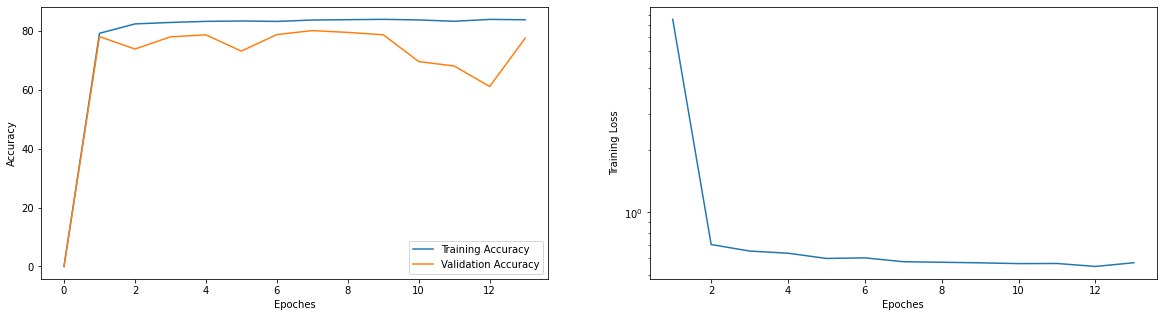

In [77]:
plot_data(train_acc_ls_2,valid_acc_ls_2,loss_ls_2 )

In [33]:
## Some optimizer to pick
# optimizer_2 = optim.SGD(model_2.parameters(),lr=0.1,momentum=0)
# optimizer_2 = Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0)
# optimizer_2 = optim.Adam(model_2.parameters(),lr=0.01,  weight_decay=0)

In [37]:
torch.manual_seed(random_seed)
input_shape = (train_set_balanced[0][0].shape[1], train_set_balanced[0][0].shape[0])
model_1 = Discriminator_BN( ngpu=1, input_shape =input_shape , out_fea = 1).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_1 = optim.Adam(model_1.parameters(),lr=0.01,  weight_decay=0)
lrscheduler_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, mode='min',patience= 2, factor = 0.1,threshold=0.01)
dataloader = (train_loader, test_loader)
model_1, best_model_1,val_score,loss_ls, train_acc_ls, valid_acc_ls = train_model(model_1,dataloader, optimizer_1, 
                                                                    criterion, lrscheduler_1, 
                                                                    n_epochs=30, patience = 5,
                                                                    checkpoint_name ="../models/torch_models/checkpoint_model_1.pt" )

Training set batch amounts: 328
Test set : 106
Start Training..
Epoch: 0,  Epoch_Loss: 8.6015, Train Acc: 77.7520 %, Train Recall: 0.7373 
Validation Acc:  66.7160 %,  Validation Recall: 0.3725 
Checkpoint Saved


Epoch: 1,  Epoch_Loss: 0.7079, Train Acc: 83.2155 %, Train Recall: 0.8007 
Validation Acc:  73.9423 %,  Validation Recall: 0.5349 
Checkpoint Saved


Epoch: 2,  Epoch_Loss: 0.6307, Train Acc: 83.9009 %, Train Recall: 0.8131 
Validation Acc:  79.4009 %,  Validation Recall: 0.7342 
Checkpoint Saved


Epoch: 3,  Epoch_Loss: 0.5847, Train Acc: 84.0417 %, Train Recall: 0.8184 
Validation Acc:  76.6420 %,  Validation Recall: 0.5791 


Epoch: 4,  Epoch_Loss: 0.5669, Train Acc: 84.1349 %, Train Recall: 0.8169 
Validation Acc:  68.6169 %,  Validation Recall: 0.5055 


Epoch: 5,  Epoch_Loss: 0.4146, Train Acc: 86.0905 %, Train Recall: 0.8384 
Validation Acc:  77.8920 %,  Validation Recall: 0.5896 


Epoch: 6,  Epoch_Loss: 0.3846, Train Acc: 86.2696 %, Train Recall: 0.8405 
Validation A

In [47]:
valid_acc_ls

[66.71597633136095,
 73.9423076923077,
 79.4008875739645,
 76.64201183431953,
 68.61686390532545,
 77.89201183431953,
 79.17899408284023,
 80.02958579881657,
 76.13905325443787,
 81.4423076923077,
 80.61390532544378,
 81.44970414201184,
 81.29437869822485,
 81.45710059171597,
 80.94674556213018,
 81.24260355029585,
 81.17603550295858,
 81.13905325443787,
 81.36094674556213,
 81.18343195266272]

In [51]:
torch.manual_seed(random_seed)
input_shape = (train_set_balanced[0][0].shape[1], train_set_balanced[0][0].shape[0])
model_2 = Discriminator_BN_Bias( ngpu=1, input_shape =input_shape , out_fea = 1).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_2 = optim.Adam(model_2.parameters(),lr=0.01,  weight_decay=0)
lrscheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, mode='min',patience= 3, factor = 0.1,threshold=0.01)
dataloader = (train_loader, test_loader)
model_2, best_model_2,val_score_2,loss_ls_2, train_acc_ls_2, valid_acc_ls_2 = train_model(model_2,dataloader, optimizer_2, 
                                                                    criterion, lrscheduler_2, 
                                                                    n_epochs=20, patience = 5,
                                                                    checkpoint_name ="../models/torch_models/checkpoint_model_2.pt" )

Training set batch amounts: 328
Test set : 106
Start Training..
Epoch: 0,  Epoch_Loss: 8.5442, Train Acc: 79.1203 %, Train Recall: 0.7691 
Validation Acc:  78.0030 %,  Validation Recall: 0.7102 
Checkpoint Saved


Epoch: 1,  Epoch_Loss: 0.7007, Train Acc: 82.3057 %, Train Recall: 0.8022 
Validation Acc:  73.7870 %,  Validation Recall: 0.6756 


Epoch: 2,  Epoch_Loss: 0.6517, Train Acc: 82.8048 %, Train Recall: 0.7983 
Validation Acc:  77.9216 %,  Validation Recall: 0.7513 


Epoch: 3,  Epoch_Loss: 0.6361, Train Acc: 83.1678 %, Train Recall: 0.8035 
Validation Acc:  78.5947 %,  Validation Recall: 0.6861 
Checkpoint Saved


Epoch: 4,  Epoch_Loss: 0.6002, Train Acc: 83.2991 %, Train Recall: 0.8126 
Validation Acc:  73.0843 %,  Validation Recall: 0.5180 


Epoch: 5,  Epoch_Loss: 0.6041, Train Acc: 83.1558 %, Train Recall: 0.8142 
Validation Acc:  78.6982 %,  Validation Recall: 0.6642 
Checkpoint Saved


Epoch: 6,  Epoch_Loss: 0.5788, Train Acc: 83.6239 %, Train Recall: 0.8168 
Validation A

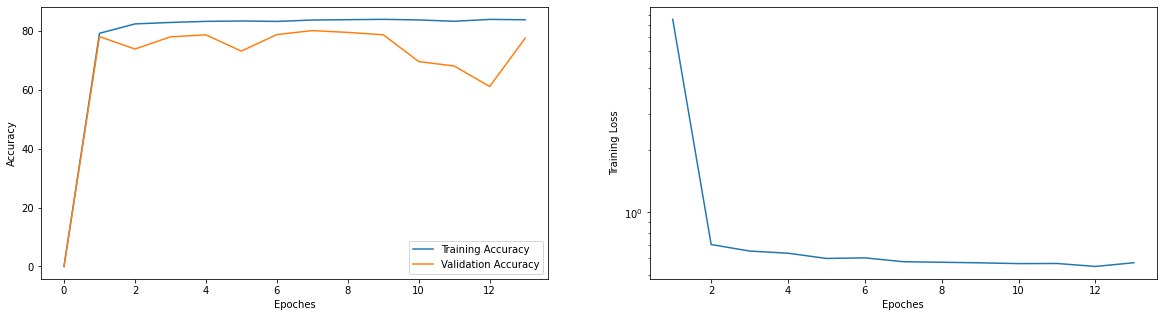

In [79]:
plot_data(train_acc_ls_2,valid_acc_ls_2,loss_ls_2 )

In [85]:
torch.manual_seed(random_seed)
input_shape = (train_set_balanced[0][0].shape[1], train_set_balanced[0][0].shape[0])
model_3 = Discriminator_BN_Bias( ngpu=1, input_shape =input_shape , out_fea = 1).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_3 = optim.Adam(model_3.parameters(),lr=0.01,  weight_decay=0.01)
lrscheduler_3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_3, mode='min',patience= 2, factor = 0.1,threshold=0.01)
dataloader = (train_loader, test_loader)
model_3, best_model_3,val_score_3,loss_ls_3, train_acc_ls_3, valid_acc_ls_3 = train_model(model_3,dataloader, optimizer_3, 
                                                                    criterion, lrscheduler_3, 
                                                                    n_epochs=30, patience = 5,
                                                                    checkpoint_name ="../models/torch_models/checkpoint_model_3.pt" )

Training set batch amounts: 328
Test set : 106
Start Training..
Epoch: 0,  Epoch_Loss: 9.0950, Train Acc: 78.5687 %, Train Recall: 0.7685 
Validation Acc:  71.4571 %,  Validation Recall: 0.5757 
Checkpoint Saved


Epoch: 1,  Epoch_Loss: 0.6485, Train Acc: 82.2819 %, Train Recall: 0.8058 
Validation Acc:  70.9393 %,  Validation Recall: 0.8195 


Epoch: 2,  Epoch_Loss: 0.6005, Train Acc: 83.0532 %, Train Recall: 0.8147 
Validation Acc:  71.2056 %,  Validation Recall: 0.5457 


Epoch: 3,  Epoch_Loss: 0.5794, Train Acc: 83.0651 %, Train Recall: 0.8133 
Validation Acc:  76.9527 %,  Validation Recall: 0.7811 
Checkpoint Saved


Epoch: 4,  Epoch_Loss: 0.4329, Train Acc: 85.5437 %, Train Recall: 0.8340 
Validation Acc:  79.9334 %,  Validation Recall: 0.7095 
Checkpoint Saved


Epoch: 5,  Epoch_Loss: 0.4002, Train Acc: 86.4535 %, Train Recall: 0.8421 
Validation Acc:  80.2145 %,  Validation Recall: 0.6963 
Checkpoint Saved


Epoch: 6,  Epoch_Loss: 0.4001, Train Acc: 86.9120 %, Train Recall: 0.8

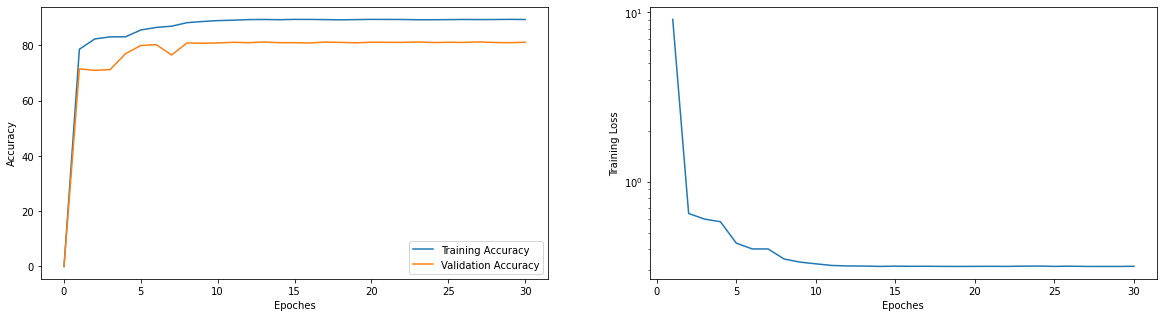

In [86]:
plot_data(train_acc_ls_3,valid_acc_ls_3,loss_ls_3 )

In [90]:
test_model = torch.load("../models/torch_models/checkpoint_model_3.pt" )
test_acc, test_recall= eval_model(test_model,test_loader)
print("Test Accuracy: %.3f , Recall: %.3f"%(test_acc, test_recall))

Test Accuracy: 81.287 , Recall: 0.750


In [93]:
from sklearn.metrics import roc_auc_score, accuracy_score
label_ls = [] 
pred_ls = []
with torch.no_grad():
        for samples, labels in test_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = test_model(samples).to(device).squeeze()
            outputs = torch.round(torch.sigmoid(outputs))
            label_ls.extend(labels.numpy().tolist())
            pred_ls.extend(outputs.numpy().tolist())
print("AUC: ", roc_auc_score(label_ls, pred_ls), "Accuracy: ", accuracy_score(label_ls, pred_ls))

AUC:  0.8121301775147929 Accuracy:  0.8121301775147929


## Model 4 with ResNet

In [108]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels ,bias= True, filter_num = 10):
        super(BasicBlock, self).__init__()       
        self.conv0 = nn.Conv1d(in_channels = in_channels, 
                               out_channels = filter_num, 
                               kernel_size= 3,  stride= 1, padding=1, bias=bias)
        self.bn0 = nn.BatchNorm1d(filter_num)
        self.relu0 = nn.ReLU()
        
        self.conv1 = nn.Conv1d(in_channels = in_channels, 
                               out_channels = filter_num, 
                               kernel_size= 3,  stride= 1, padding=1, bias=bias)
        self.bn1 = nn.BatchNorm1d(filter_num)
        self.relu1 = nn.ReLU()
        pass
    def forward(self, x):
        residual = x
        out = self.conv0(x)
        out = self.bn0(out)
        out = self.relu0(out)
        out = self.conv1(out)
        out = self.bn1(out)
        
        out += residual
        out = self.relu1(out)
        
        return out

class Discriminator_ResNet(nn.Module):
    def __init__(self, ngpu, input_shape , out_fea = 1):
        super(Discriminator_ResNet, self).__init__()
        
        # (input_shape[0], input_shape[1] )=  (number of data point, 6 axis channel )
        in_channels, win_size = input_shape[0], input_shape[1]
        self.in_channels = in_channels
        self.ngpu = ngpu  
        self.out_fea = out_fea
        filter_num = 10
        
        self.conv0 = nn.Conv1d(in_channels = self.in_channels, 
                               out_channels = filter_num, 
                               kernel_size= 44,  stride= 2, padding=0, bias=True)
        
        self.relu0= nn.ReLU()
        num_fea = (win_size-44)//2 +1
        self.conv1 = nn.Conv1d(filter_num,filter_num, kernel_size= 20,stride= 2, padding=0, bias=True)
        self.relu1= nn.ReLU()
        self.bn1 = nn.BatchNorm1d(filter_num)
        
        self.block1 =  BasicBlock( in_channels=filter_num  ,bias= True, filter_num = filter_num)
        self.block2 =  BasicBlock( in_channels=filter_num  ,bias= True, filter_num = filter_num)
        
        
        self.avgpool = nn.AvgPool1d(kernel_size=10)
        self.flatten = nn.Flatten()
        self.linear1 = None 
        self.relu2 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=200, out_features=out_fea, bias=True)
        self.softmax = nn.Softmax(dim=out_fea)
        self.sigmoid = nn.Sigmoid()
        
        nn.init.normal_(self.conv0.weight.data, 0.0, 1.)
        nn.init.normal_(self.conv1.weight.data, 0.0, 1.)
        nn.init.normal_(self.linear2.bias.data, 0.0, 1.)
        
    def l1_loss(self,factor=0.01):
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        loss = 0.
        layers = [self.conv0, self.conv1]
        for layer in layers:
            for p in layer.parameters():
                #print(p)
                reg_loss += l1_crit(p, torch.zeros(p.shape))

        loss = factor * reg_loss
        return loss

    
    def forward(self, input):

        x = input.permute(0,2,1)
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.conv1(x)
        x=  self.bn1(x)
        x = self.relu1(x)
        x = self.block1(x)
        x = self.block2(x)

        
        x = self.avgpool(x)
        #print("Pooling shape:",x.shape)
        x = self.flatten(x)
        if self.linear1 == None:
            self.linear1 = nn.Linear(in_features=x.shape[1], out_features=200, bias=True)
            nn.init.normal_(self.linear1.weight.data, 0.0, 1.)
            nn.init.normal_(self.linear1.bias.data, 0.0, 1.)
            
        x = self.relu2(self.linear1(x))
        out = self.linear2(x)

        return out

In [109]:
torch.manual_seed(random_seed)
input_shape = (train_set_balanced[0][0].shape[1], train_set_balanced[0][0].shape[0])
model_4 = Discriminator_ResNet( ngpu=1, input_shape =input_shape , out_fea = 1).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_4 = optim.Adam(model_4.parameters(),lr=0.01,  weight_decay=0.1)
lrscheduler_4 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_4, mode='min',patience= 2, factor = 0.1,threshold=0.01)
dataloader = (train_loader, test_loader)
model_4, best_model_4,val_score_4,loss_ls_4, train_acc_ls_4, valid_acc_ls_4 = train_model(model_4,dataloader, optimizer_4, 
                                                                    criterion, lrscheduler_4, 
                                                                    n_epochs=30, patience = 5, l1_enabled=False,
                                                                    checkpoint_name ="../models/torch_models/checkpoint_model_4.pt" )

Training set batch amounts: 328
Test set : 106
Start Training..
Epoch: 0,  Epoch_Loss: 0.4649, Train Acc: 80.8587 %, Train Recall: 0.7670 
Validation Acc:  50.6657 %,  Validation Recall: 0.0136 
Checkpoint Saved


Epoch: 1,  Epoch_Loss: 0.3764, Train Acc: 84.3187 %, Train Recall: 0.8013 
Validation Acc:  79.5784 %,  Validation Recall: 0.7598 
Checkpoint Saved


Epoch: 2,  Epoch_Loss: 0.3791, Train Acc: 84.2375 %, Train Recall: 0.8060 
Validation Acc:  53.9941 %,  Validation Recall: 0.0806 


Epoch: 3,  Epoch_Loss: 0.3775, Train Acc: 84.2996 %, Train Recall: 0.8046 
Validation Acc:  76.7086 %,  Validation Recall: 0.5962 


Epoch: 4,  Epoch_Loss: 0.2969, Train Acc: 87.9698 %, Train Recall: 0.8473 
Validation Acc:  80.5621 %,  Validation Recall: 0.7528 
Checkpoint Saved


Epoch: 5,  Epoch_Loss: 0.2634, Train Acc: 89.6748 %, Train Recall: 0.8720 
Validation Acc:  80.8432 %,  Validation Recall: 0.7357 
Checkpoint Saved


Epoch: 6,  Epoch_Loss: 0.2448, Train Acc: 90.6657 %, Train Recall: 0.8

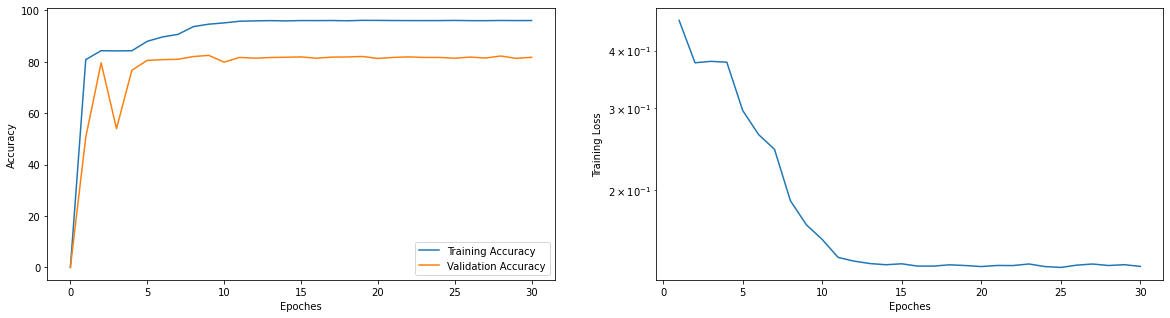

In [110]:
plot_data(train_acc_ls_4,valid_acc_ls_4,loss_ls_4 )

In [189]:
from sklearn.metrics import roc_auc_score, accuracy_score,recall_score
import random

torch.manual_seed(random_seed)
random.seed(random_seed)
label_ls = [] 
pred_ls = []
prob_ls = []
test_model = torch.load("../models/torch_models/checkpoint_model_4.pt" )
test_loader.shuffle=False

data_test = Person_MealsDataset(person_name= "wenkanw", file_name = "test_files", winmin = winmin,stridesec = winmin*60)

test_indices = balance_data_indices(data_test.labels,mode="under", shuffle=False)
test_balanced = torch.utils.data.Subset(data_test, test_indices)
data = torch.utils.data.DataLoader(test_balanced ,batch_size=256, shuffle=False,num_workers=2)


# data = torch.utils.data.DataLoader(data_test ,batch_size=256, shuffle=False,num_workers=2)
with torch.no_grad():
        for samples, labels in data:
#             samples = samples.view(1,samples.shape[0],samples.shape[1] )
#             labels = torch.tensor(labels).view(1,1)
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = test_model(samples).to(device).squeeze()
            proba = torch.sigmoid(outputs)
            prob_ls.extend(proba.tolist())
            outputs = proba>=0.6
            label_ls.extend(labels.numpy().tolist())
            pred_ls.extend(outputs.numpy().tolist())
print("AUC: ", roc_auc_score(label_ls, pred_ls), "Accuracy: ", accuracy_score(label_ls, pred_ls),"Recall: ",recall_score(label_ls, pred_ls))

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/10-10-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
AUC:  0.8141592920353982 Accuracy:  0.8141592920353983 Recall:  0.7079646017699115


In [229]:
a = [1,2,3,4,5,6,7]
b = [-1,-2,-3,-4,-5]
c = [0,1,2,4,5,90]
random_s = 1
mode = "under"
if random_s != None:
        np.random.seed(random_s)
if mode == "over":
        a = np.random.choice(a,len(a)-1).tolist()
        pass
elif mode == "under":
        b = np.random.choice(b,len(b)-1).tolist()
np.random.shuffle(c)
a,b,c

([1, 2, 3, 4, 5, 6, 7], [-4, -5, -1, -2], [2, 90, 1, 5, 0, 4])

/home/wenkanw/.conda/envs/mlenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/wenkanw/.conda/envs/mlenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


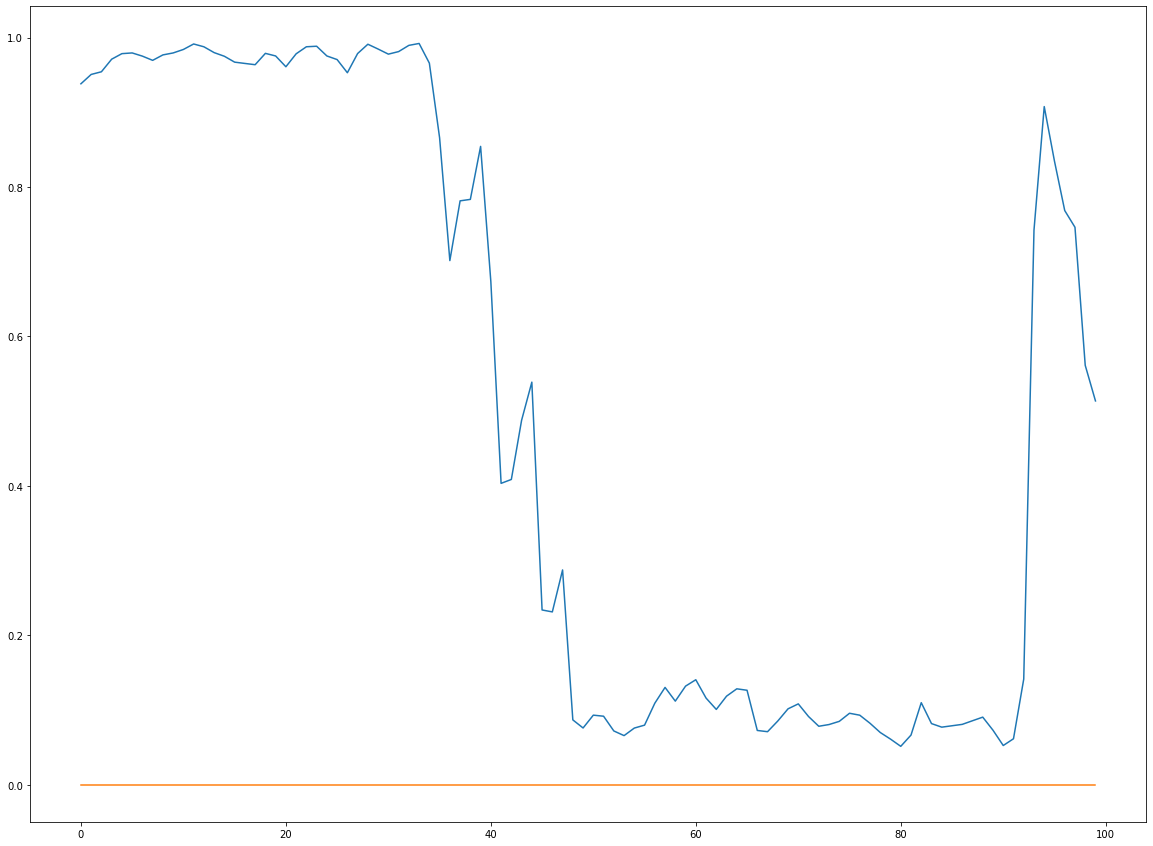

In [144]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
_= sns.lineplot(np.arange(len(prob_ls[:100])),prob_ls[:100],ax= ax)
_ = sns.lineplot(np.arange(len(label_ls[:100])),label_ls[:100],ax= ax)

In [138]:
meal_data_test[0][0].view(1,meal_data_test[0][0].shape[0],meal_data_test[0][0].shape[1] )

tensor([[[ 3.2014, -0.8717,  2.3412,  0.2717,  1.1494, -1.2837],
         [ 0.1216, -1.3664, -3.8213,  0.5289, -1.8453, -1.0834],
         [-0.8812, -4.3935,  4.7427,  5.5154, -2.0513,  2.2311],
         ...,
         [-1.4969,  0.4735,  2.0557, -1.4770, -1.2231, -3.3272],
         [-1.4022,  0.6860,  2.5945, -1.7465, -1.0695, -3.3440],
         [-1.1492,  0.1034,  3.0641, -1.9749, -0.9223, -3.4571]]])

# Model 5 ResNet without BN

In [4]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels ,bias= True, filter_num = 10, batch_norm = False):
        super(BasicBlock, self).__init__()       
        self.bn_flag = batch_norm
        self.conv0 = nn.Conv1d(in_channels = in_channels, 
                               out_channels = filter_num, 
                               kernel_size= 3,  stride= 1, padding=1, bias=bias)
        self.bn0 = nn.BatchNorm1d(filter_num)
        self.relu0 = nn.ReLU()
        
        self.conv1 = nn.Conv1d(in_channels = in_channels, 
                               out_channels = filter_num, 
                               kernel_size= 3,  stride= 1, padding=1, bias=bias)
        self.bn1 = nn.BatchNorm1d(filter_num)
        self.relu1 = nn.ReLU()
        pass
    def forward(self, x):
        residual = x
        out = self.conv0(x)
        if self.bn_flag:
            out = self.bn0(out)
            
        out = self.relu0(out)
        out = self.conv1(out)
        
        if self.bn_flag:
            out = self.bn1(out)
        
        out += residual
        out = self.relu1(out)
        
        return out

class Discriminator_ResNet2(nn.Module):
    def __init__(self, ngpu, input_shape , out_fea = 1,bn=False):
        super(Discriminator_ResNet2, self).__init__()
        
        # (input_shape[0], input_shape[1] )=  (number of data point, 6 axis channel )
        win_size, in_channels = input_shape[0], input_shape[1]
        self.in_channels = in_channels
        self.ngpu = ngpu  
        self.out_fea = out_fea
        filter_num = 10
        self.bn = bn
        self.conv0 = nn.Conv1d(in_channels = self.in_channels, 
                               out_channels = filter_num, 
                               kernel_size= 44,  stride= 2, padding=0, bias=True)
        
        self.relu0= nn.ReLU()
        num_fea = (win_size-44)//2 +1
        self.conv1 = nn.Conv1d(filter_num,filter_num, kernel_size= 20,stride= 2, padding=0, bias=True)
        self.relu1= nn.ReLU()
        self.bn1 = nn.BatchNorm1d(filter_num)
        
        self.block1 =  BasicBlock( in_channels=filter_num  ,bias= True, filter_num = filter_num, batch_norm = self.bn)
        self.block2 =  BasicBlock( in_channels=filter_num  ,bias= True, filter_num = filter_num, batch_norm = self.bn)
        
        
        self.avgpool = nn.AvgPool1d(kernel_size=10)
        self.flatten = nn.Flatten()
        self.linear1 = None 
        self.relu2 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=200, out_features=out_fea, bias=True)
        self.softmax = nn.Softmax(dim=out_fea)
        self.sigmoid = nn.Sigmoid()
        
        nn.init.normal_(self.conv0.weight.data, 0.0, 1.)
        nn.init.normal_(self.conv1.weight.data, 0.0, 1.)
        nn.init.normal_(self.linear2.bias.data, 0.0, 1.)
        
    def l1_loss(self,factor=0.01):
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        loss = 0.
        layers = [self.conv0, self.conv1]
        for layer in layers:
            for p in layer.parameters():
                #print(p)
                reg_loss += l1_crit(p, torch.zeros(p.shape))

        loss = factor * reg_loss
        return loss

    
    def forward(self, input):

        x = input.permute(0,2,1)
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.conv1(x)
        x=  self.bn1(x)
        x = self.relu1(x)
#         x = self.block1(x)
        x = self.block2(x)

        
        x = self.avgpool(x)
        #print("Pooling shape:",x.shape)
        x = self.flatten(x)
        if self.linear1 == None:
            self.linear1 = nn.Linear(in_features=x.shape[1], out_features=200, bias=True)
            nn.init.normal_(self.linear1.weight.data, 0.0, 1.)
            nn.init.normal_(self.linear1.bias.data, 0.0, 1.)
            
        x = self.relu2(self.linear1(x))
        out = self.linear2(x)

        return out

In [5]:
from utils import *

torch.manual_seed(random_seed)
input_shape = (train_set_balanced[0][0].shape[0], train_set_balanced[0][0].shape[1])
model_4 = Discriminator_ResNet2( ngpu=1, input_shape =input_shape , out_fea = 1,bn=True)
# Since I use a dynamic created layer in network, need to input a sample to initialize the model first
_ = model_4(torch.rand((1, input_shape[0],input_shape[1])))
model_4.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_4 = optim.Adam(model_4.parameters(),lr=0.01,  weight_decay=0.1)
lrscheduler_4 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_4, mode='min',patience= 2, factor = 0.1,threshold=0.01)
dataloader = (train_loader, test_loader)
model_4, best_model_4,val_score_4,loss_ls_4, train_acc_ls_4, valid_acc_ls_4 = train_model(model_4,dataloader, optimizer_4, 
                                                                    criterion, lrscheduler_4, device= device,
                                                                    n_epochs=30, patience = 5, l1_enabled=False)

Training set batch amounts: 328
Test set : 106
Start Training..
Epoch: 0,  Epoch_Loss: 0.4591, Train Acc: 80.9638 %, Train Recall: 0.7704 
Validation Acc:  73.6834 %,  Validation Recall: 0.6306 
Checkpoint Saved


Epoch: 1,  Epoch_Loss: 0.4231, Train Acc: 83.0197 %, Train Recall: 0.7902 
Validation Acc:  74.0311 %,  Validation Recall: 0.8485 
Checkpoint Saved


Epoch: 2,  Epoch_Loss: 0.4285, Train Acc: 82.7762 %, Train Recall: 0.7859 
Validation Acc:  70.3328 %,  Validation Recall: 0.9442 




KeyboardInterrupt: 

In [6]:
from utils import *

torch.manual_seed(random_seed)
input_shape = (train_set_balanced[0][0].shape[0], train_set_balanced[0][0].shape[1])
model_4 = Discriminator_ResNet2( ngpu=1, input_shape =input_shape , out_fea = 1,bn=False)
# Since I use a dynamic created layer in network, need to input a sample to initialize the model first
_ = model_4(torch.rand((1, input_shape[0],input_shape[1])))
model_4.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_4 = optim.Adam(model_4.parameters(),lr=0.01,  weight_decay=0.1)
lrscheduler_4 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_4, mode='min',patience= 2, factor = 0.1,threshold=0.01)
dataloader = (train_loader, test_loader)
model_4, best_model_4,val_score_4,loss_ls_4, train_acc_ls_4, valid_acc_ls_4 = train_model(model_4,dataloader, optimizer_4, 
                                                                    criterion, lrscheduler_4, device= device,
                                                                    n_epochs=30, patience = 5, l1_enabled=False)

Training set batch amounts: 328
Test set : 106
Start Training..
Epoch: 0,  Epoch_Loss: 0.5714, Train Acc: 74.4878 %, Train Recall: 0.6997 
Validation Acc:  65.0296 %,  Validation Recall: 0.3583 
Checkpoint Saved


Epoch: 1,  Epoch_Loss: 0.4577, Train Acc: 81.2336 %, Train Recall: 0.7633 
Validation Acc:  75.9763 %,  Validation Recall: 0.7740 
Checkpoint Saved


Epoch: 2,  Epoch_Loss: 0.4592, Train Acc: 81.4389 %, Train Recall: 0.7716 
Validation Acc:  70.7692 %,  Validation Recall: 0.7891 




KeyboardInterrupt: 

# model 6

In [11]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels ,bias= True, filter_num = 10, batch_norm = False):
        super(BasicBlock, self).__init__()       
        self.bn_flag = batch_norm
        self.conv0 = nn.Conv1d(in_channels = in_channels, 
                               out_channels = filter_num, 
                               kernel_size= 3,  stride= 1, padding=1, bias=bias)
        self.bn0 = nn.BatchNorm1d(filter_num)
        self.relu0 = nn.ReLU()
        
        self.conv1 = nn.Conv1d(in_channels = in_channels, 
                               out_channels = filter_num, 
                               kernel_size= 3,  stride= 1, padding=1, bias=bias)
        self.bn1 = nn.BatchNorm1d(filter_num)
        self.relu1 = nn.ReLU()
        pass
    def forward(self, x):
        residual = x
        out = self.conv0(x)
        if self.bn_flag:
            out = self.bn0(out)
            
        out = self.relu0(out)
        out = self.conv1(out)
        
        if self.bn_flag:
            out = self.bn1(out)
        
        out += residual
        out = self.relu1(out)
        
        return out

class Discriminator_ResNet3(nn.Module):
    def __init__(self, ngpu, input_shape , out_fea = 1,bn=False):
        super(Discriminator_ResNet3, self).__init__()
        
        # (input_shape[0], input_shape[1] )=  (number of data point, 6 axis channel )
        win_size, in_channels = input_shape[0], input_shape[1]
        self.in_channels = in_channels
        self.ngpu = ngpu  
        self.out_fea = out_fea
        filter_num = 10
        self.bn = bn
        self.conv0 = nn.Conv1d(in_channels = self.in_channels, 
                               out_channels = filter_num, 
                               kernel_size= 64,  stride= 2, padding=0, bias=True)
        
        self.relu0= nn.ReLU()
        num_fea = (win_size-44)//2 +1
        self.conv1 = nn.Conv1d(filter_num,filter_num, kernel_size= 20,stride= 2, padding=0, bias=True)
        self.relu1= nn.ReLU()
        self.bn1 = nn.BatchNorm1d(filter_num)
        
        self.block1 =  BasicBlock( in_channels=filter_num  ,bias= True, filter_num = filter_num, batch_norm = self.bn)
        self.block2 =  BasicBlock( in_channels=filter_num  ,bias= True, filter_num = filter_num, batch_norm = self.bn)
        
        
        self.avgpool = nn.AvgPool1d(kernel_size=10)
        self.flatten = nn.Flatten()
        self.linear1 = None 
        self.relu2 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=200, out_features=out_fea, bias=True)
        self.softmax = nn.Softmax(dim=out_fea)
        self.sigmoid = nn.Sigmoid()
        
        nn.init.normal_(self.conv0.weight.data, 0.0, 1.)
        nn.init.normal_(self.conv1.weight.data, 0.0, 1.)
        nn.init.normal_(self.linear2.bias.data, 0.0, 1.)
        
    def l1_loss(self,factor=0.01):
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        loss = 0.
        layers = [self.conv0, self.conv1]
        for layer in layers:
            for p in layer.parameters():
                #print(p)
                reg_loss += l1_crit(p, torch.zeros(p.shape))

        loss = factor * reg_loss
        return loss

    
    def forward(self, input):

        x = input.permute(0,2,1)
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.block1(x)
        x = self.block2(x)

        
        x = self.avgpool(x)
        #print("Pooling shape:",x.shape)
        x = self.flatten(x)
        if self.linear1 == None:
            self.linear1 = nn.Linear(in_features=x.shape[1], out_features=200, bias=True)
            nn.init.normal_(self.linear1.weight.data, 0.0, 1.)
            nn.init.normal_(self.linear1.bias.data, 0.0, 1.)
            
        x = self.relu2(self.linear1(x))
        out = self.linear2(x)

        return out

In [13]:
from utils import *

torch.manual_seed(random_seed)
input_shape = (train_set_balanced[0][0].shape[0], train_set_balanced[0][0].shape[1])
model_4 = Discriminator_ResNet3( ngpu=1, input_shape =input_shape , out_fea = 1,bn=True)
# Since I use a dynamic created layer in network, need to input a sample to initialize the model first
_ = model_4(torch.rand((1, input_shape[0],input_shape[1])))
model_4.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_4 = optim.Adam(model_4.parameters(),lr=0.01,  weight_decay=0.1)
lrscheduler_4 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_4, mode='min',patience= 2, factor = 0.1,threshold=0.01)
dataloader = (train_loader, test_loader)
model_4, best_model_4,val_score_4,loss_ls_4, train_acc_ls_4, valid_acc_ls_4 = train_model(model_4,dataloader, optimizer_4, 
                                                                    criterion, lrscheduler_4, device= device,
                                                                    n_epochs=30, patience = 5, l1_enabled=False)

Training set batch amounts: 328
Test set : 106
Start Training..
Epoch: 0,  Epoch_Loss: 2.5393, Train Acc: 75.5122 %, Train Recall: 0.7341 
Validation Acc:  75.5251 %,  Validation Recall: 0.6268 
Checkpoint Saved


Epoch: 1,  Epoch_Loss: 0.4060, Train Acc: 83.9892 %, Train Recall: 0.7975 
Validation Acc:  76.4201 %,  Validation Recall: 0.6277 
Checkpoint Saved


Epoch: 2,  Epoch_Loss: 0.4019, Train Acc: 83.5355 %, Train Recall: 0.8003 
Validation Acc:  78.8536 %,  Validation Recall: 0.6428 
Checkpoint Saved


Epoch: 3,  Epoch_Loss: 0.4000, Train Acc: 83.2967 %, Train Recall: 0.7958 
Validation Acc:  70.2367 %,  Validation Recall: 0.4762 


Epoch: 4,  Epoch_Loss: 0.4014, Train Acc: 83.2585 %, Train Recall: 0.7951 
Validation Acc:  71.8787 %,  Validation Recall: 0.7056 


Epoch: 5,  Epoch_Loss: 0.4062, Train Acc: 83.0890 %, Train Recall: 0.7932 
Validation Acc:  73.4024 %,  Validation Recall: 0.7075 


Epoch: 6,  Epoch_Loss: 0.4030, Train Acc: 83.0579 %, Train Recall: 0.7915 
Validation A

KeyboardInterrupt: 